In [18]:
import re
import tempfile
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from qiime2 import Artifact
from qiime2.plugins.feature_classifier.methods import classify_consensus_vsearch
%matplotlib inline

In [84]:
def get_expected_results(path):
    """From a mockrobiota expected results fasta file, load sequences and their
    scientific name into a dataframe
        
    Parameters
    ----------
    path: path to the expected fasta file; str
    """
    
    sequences = []
    genera = []
    species_list = []

    with open(path) as expected: 
        for line in expected:
            #this is a header line; strip the > and newline character from it
            if line.startswith('>'):
                line = line.strip('>')
                line = line.strip('\n')
                #capture each word in the header into a list. The first two
                #words are the scientific name
                line_list = re.split(' |_', line)
                genus, species = line_list[:2]
                genera.append(genus)
                species_list.append(species)
            else:
                sequence = line.strip('\n')
                sequences.append(sequence)
    #we're left with 3 lists that we can combine into a dataframe
    results = pd.DataFrame(list(zip(sequences, genera, species_list)),
                           columns = ['sequence', 'genus', 'species'])
    
    return results

In [85]:
def get_sequences(path):

    """given the path of a 'representative sequences' quality controlled qiime2 artifact,
    return a dictionary with the hashes mapped to the sequences
    
    Parameters
    ----------
    path: the filepath of the .qza file exported from the rep_seqs artifact; str
    """
    
    with tempfile.TemporaryDirectory() as temp_dir:
        temp = Artifact.load(path)
        temp.export_data(temp_dir)
        
        hashes = []
        sequences = []
        with open(temp_dir + '/dna-sequences.fasta') as sequence_file:
            for line in sequence_file:
                if line.startswith('>'):
                    hashed_seq = line.lstrip('>')
                    hashed_seq = hashed_seq.rstrip('\n')
                    hashes.append(hashed_seq)
                else:
                    sequences.append(line.rstrip('\n'))
        results = dict(zip(hashes, sequences))
        
    return results

In [21]:
def get_assigned_taxonomy(classification_taxonomy, sequence_keys):
    """given a 'classification taxonomy' qiime2 artifact and a hash-sequence
    dict, return a dataframe of sequences plus their 7-level taxonomy.
    
    Parameters
    ----------
    classification_taxonomy: an artifact created by a qiime2 feature-classifer
                             method; FeatureData[Taxonomy] artifact
    
    sequence_keys: a dict of the hashes mapped to the full sequence; dict
    """
    
    hashes = []
    taxonomy_strings = []
    sequences = []
    kingdoms = []
    phyla = []
    classes = []
    orders = []
    families = []
    genera = []
    species_list = []
    hierarchy = ['k','p','c','o','f','g','s']
    #I'm not familiar enough with the API to extract the necessary data directly
    #from the artifact, so I export it to a temporary directory and grab the tsv
    #file from there.
    with tempfile.TemporaryDirectory() as temp_dir:
        classification_taxonomy.export_data(temp_dir)
        with open(temp_dir + '/taxonomy.tsv') as taxonomy_file:
            for line in taxonomy_file:
                #Feature ID is the header row
                if not line.startswith('Feature ID'):
                    #these are the columns, we capture them in a list. Since the
                    #final result is a dataframe, it might be more reasonable to
                    #import into a df, but I think dfs get pretty messy pretty
                    #quick when you start manipulating them. I'm also not sure
                    #about the relative speed of operations
                    hashed_sequence, taxonomy_string, consensus = line.split('\t')
                    hashes.append(hashed_sequence)
                    taxonomy_strings.append(taxonomy_string)
    #find the sequence associated with the hash and build a list of the actual
    #sequences
    for hashed_sequence in hashes:
        sequence = sequence_keys[hashed_sequence]
        sequences.append(sequence)
    #here i expand out each string to an excessive number of unassigneds to
    #ensure that there are at least 7 levels in every string, then capture the
    #first seven assignments into their respective level. Lots of formatting
    #adjustments.
    for taxonomy_string in taxonomy_strings:
        if taxonomy_string.startswith('Unassigned'):
            kingdom = 'Unassigned'
            phylum = 'Unassigned'
            taxon_class = 'Unassigned'
            order = 'Unassigned'
            family = 'Unassigned'
            genus = 'Unassigned'
            species = 'Unassigned'
        else:
            temp_string = taxonomy_string + '; Unassigned' * 6
            for rank in hierarchy:
                temp_string = temp_string.replace((rank + "__; "), "")
                temp_string = temp_string.replace((rank + "__"), "")
            temp_string = temp_string.replace('; ;', '; Unassigned;')
            kingdom, phylum, taxon_class, order, family, genus, species, _ = temp_string.split('; ', 7)
        kingdoms.append(kingdom)
        phyla.append(phylum)
        classes.append(taxon_class)
        orders.append(order)
        families.append(family)
        genera.append(genus)
        species_list.append(species)
    results = pd.DataFrame(list(zip(sequences, kingdoms, phyla, classes, orders,
                                    families, genera, species_list)),
                           columns =['sequence', 'kingdom', 'phylum', 'class',
                                     'order', 'family', 'genus', 'species'])
    
    return results

In [22]:
def calculate_match(observed_df, expected_df, level):
    """Compare two dataframes at the specified taxonomic level. Dataframes are
    matched by searching the observed sequence against the expected sequence.
    Returns a list of the number of true positives, false positives, false
    negatives, and sequences that could not be matched.

    Parameters
    ----------
    observed_df: dataframe with sequence and taxonomy columns, taken from a
                 classification-taxonomy artifact; df
    expected_df: dataframe with sequence and taxonomy columns, taken from a
                 mockrobiota expected-taxonomy file; df
    level: taxonomic level at which to compare dataframes; str or int.
    """
    #if the classfier correctly annotated the sequence, it's a true positive
    true_positives = 0
    #if the classifier couldn't assign it, we're calling it a false negative
    false_negatives = 0
    #if the classifier assigned it but got it wrong it is a false positive
    false_positives = 0
    #some observed sequences are not found in the expected taxonomy file. not
    #sure if this is due to the quality control steps or some other aspect. it
    #should not differ across references.
    unmatched=0

    #if an integer was passed as taxonomic level, convert it to the string
    if type(level) == int:
        levels = {1:'kingdom', 2:'phylum', 3:'class', 4:'order', 5:'family',
                  6:'genus', 7:'species'}
        level = levels[level]

    #iterate down the observed dataframe
    for row in observed_df.iterrows():
        #grab the value from the 'sequence' column of the observed df
        query_seq = row[1]['sequence']
        #search the expected dataframe for that sequence and grab that row
        seq_match = (expected_df[expected_df['sequence'].str.contains(query_seq)])
        seq_match = seq_match.reset_index(drop=True)
        #if there's no match, the df will be empty. if not, we have a match
        if not seq_match.empty:
            #grab the assigned taxonomic name at the specified level
            query = row[1][level]
            #grab the reference taxonomic name at the specified level
            expected = seq_match.loc[0][level]
            if query == 'Unassigned':
                false_negatives += 1
            elif query != expected:
                false_positives += 1
            elif query == expected:
                true_positives += 1
        #if the dataframe was empty the sequence couldn't be matched
        else:
            unmatched += 1
    #store the results in a list
    results = [true_positives, false_positives, false_negatives, unmatched]

    return results

In [72]:
working_dir = '/mnt/c/Users/Dylan/Documents/zaneveld/GCMP_Global_Disease-master/analysis/organelle_removal'
list_of_mocks = [12,13,14,15,16,18,19,20,21,22]
references = ['greengenes', 'greengenes_metaxa2']

In [75]:
stats = []
for level in ['genus', 'species']:
    for mock_number in list_of_mocks:
        path = (working_dir + '/tax-credit/data/mock-community/mock-' +
                str(mock_number) + '/expected-sequences.fasta')
        #load the expected results into a dataframe
        expected_results = get_expected_results(path)
        #load the rep_seqs into variable
        seqs_path = (working_dir + '/mock-community/mock-' +
                     str(mock_number) + '/rep_seqs.qza')
        seq_artifact = Artifact.load(seqs_path)
        sequence_keys = get_sequences(seqs_path)
        for reference in references:
            reference_read_path = (working_dir + '/output/taxonomy_references/' + reference +
                                   '_otus.qza')
            reference_reads = Artifact.load(reference_read_path)
            reference_taxonomy_path = (working_dir + '/output/taxonomy_references/' +
                                       reference + '_taxonomy.qza')
            reference_taxonomy = Artifact.load(reference_taxonomy_path)
            classification_taxonomy, = classify_consensus_vsearch(query = seq_artifact,
                                                                  reference_reads = reference_reads,
                                                                  reference_taxonomy = reference_taxonomy,
                                                                  threads = 4) 
            df = get_assigned_taxonomy(classification_taxonomy = classification_taxonomy,
                                       sequence_keys = sequence_keys)
            tp, fp, fn, u = calculate_match(df, expected_results,
                                            level)
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f_measure = 2 * ((precision * recall) / (precision +
                                                     recall))
            stats.append([mock_number, reference, tp, fp, fn, precision, recall, f_measure, u, level])
results_df = pd.DataFrame(stats, columns =['mock', 'reference', 'true_positives', 'false_positives', 'false_negatives', 'precision', 'recall', 'f_measure', 'unmatched', 'level'])
results_df.to_csv('compare_accuracy.csv')

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-yl7z9fad/56f99adf-238a-45b9-bf99-6185e4b56c66/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp/qiime2-archive-b8yzho4h/06e4eff3-98c7-4e22-af11-51fbfd3493a5/data/dna-sequences.fasta --threads 4 --output_no_hits --blast6out /tmp/tmpp20uzqpq

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-yl7z9fad/56f99adf-238a-45b9-bf99-6185e4b56c66/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-8m_ufdrp/db82cd99-6bb0-4cc1-b571-3d70f3222f24/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp/qiime2-archive-o4omaeum/eb74a00d-8f2d-4c88-a313-3e014e2800e6/data/dna-sequences.fasta --threads 4 --output_no_hits --blast6out /tmp/tmpzog_wbe7

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-hv53l1vy/e503e2f7-5ad0-486e-8470-e0525adbbda2/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-uhyjiaqa/f25acef0-29cf-474a-9af4-8b8a1ea0b664/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp/qiime2-archive-lxcnovzn/06e4eff3-98c7-4e22-af11-51fbfd3493a5/data/dna-sequences.fasta --threads 4 --output_no_hits --blast6out /tmp/tmpcq0na1j2

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-uhyjiaqa/f25acef0-29cf-474a-9af4-8b8a1ea0b664/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp

In [80]:
results = results_df.loc[:,['f_measure', 'level', 'mock', 'reference']]
results

,f_measure,level,mock,reference
0,0.790698,genus,12,greengenes
1,0.790698,genus,12,greengenes_metaxa2
2,0.952381,genus,13,greengenes
3,0.952381,genus,13,greengenes_metaxa2
4,0.953846,genus,14,greengenes
5,0.953846,genus,14,greengenes_metaxa2
6,0.953846,genus,15,greengenes
7,0.953846,genus,15,greengenes_metaxa2
8,0.747253,genus,16,greengenes
9,0.747253,genus,16,greengenes_metaxa2


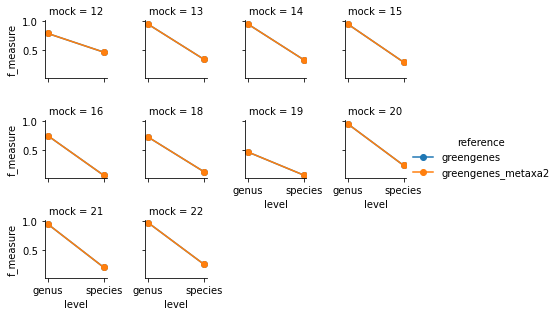

In [81]:
grid = sns.FacetGrid(results, col='mock', hue = 'reference', col_wrap = 4, height = 1.5, legend_out = True)
grid.map(plt.plot, "level", "f_measure", marker = "o").add_legend()
plt.show()

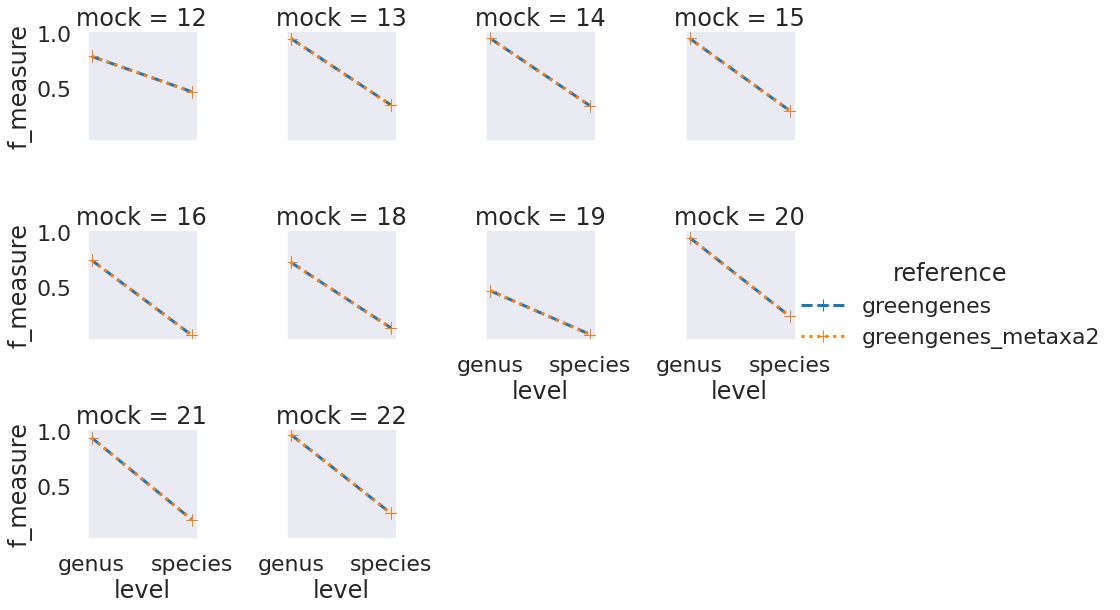

In [83]:
sns.set_style("dark")
sns.set_context("poster")
d = {"ls" : ["dashed","dotted"]}
grid = sns.FacetGrid(results, col='mock', hue = 'reference', col_wrap = 4, height = 3, hue_kws=d)
g = grid.map(plt.plot, "level", "f_measure", marker = "+").add_legend()
plt.show()